<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -a 'Author: James Bourbeau' -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


Author: James Bourbeau 
last updated: 2017-05-11 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.1
scipy 0.19.0
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.6.0


# Fraction correctly identified
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)

In [2]:
from __future__ import division, print_function
from collections import defaultdict
import itertools
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pyprind

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import comptools as comp
import comptools.analysis.plotting as plotting
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
config = 'IC79'
comp_class = True
target = 'MC_comp_class' if comp_class else 'MC_comp'
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

In [4]:
pipeline_str = 'GBDT'
pipeline = comp.get_pipeline(pipeline_str)

Define energy binning for this analysis

In [5]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [6]:
sim_train, sim_test = comp.load_dataframe(datatype='sim', config=config, target=target)

Starting out with 398044 events
sim quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:  0.776  0.776
       passed_InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75




In [7]:
len(sim_train) + len(sim_test)

298466

In [8]:
feature_list = ['lap_cos_zenith', 'log_s125', 'log_dEdX', 'invqweighted_inice_radius_1_60']
feature_list, feature_labels = comp.analysis.get_training_features(feature_list)

## Fraction correctly identified
[ [back to top](#top) ]

Calculate classifier performance via 10-fold CV

In [9]:
frac_correct_folds = comp.analysis.get_CV_frac_correct(sim_train, feature_list, pipeline_str, comp_list)
frac_correct_gen_err = {key: np.std(frac_correct_folds[key], axis=0) for key in frac_correct_folds}

Using scikit-learn GradientBoostingClassifier...
Running 10 folds in parallel...
Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4
Completed fold 5
Completed fold 6
Completed fold 7
Completed fold 8
Completed fold 9


#### Plot fraction of events correctlty classified vs energy
This is done via 10-fold cross-validation. This will give an idea as to how much variation there is in the classifier due to different trainig and testing samples. 

light
heavy
total


/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


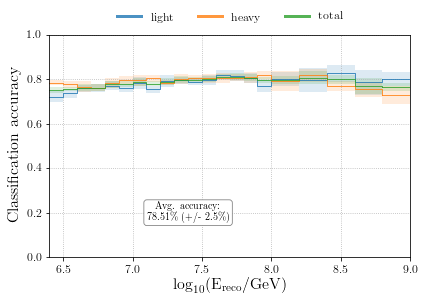

In [10]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    print(composition)
    performance_mean = np.mean(frac_correct_folds[composition], axis=0)
    performance_std = np.std(frac_correct_folds[composition], axis=0)
#     err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_bins, performance_mean, yerr=performance_std,
                        ax=ax, color=color_dict[composition], label=composition)
plt.xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('Classification accuracy')
# ax.set_ylabel('Classification accuracy \n (statistical + 10-fold CV error)')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Avg. accuracy:\n{:0.2f}\% (+/- {:0.1f}\%)'.format(np.mean(frac_correct_folds['total'])*100,
                                                      np.std(frac_correct_folds['total'])*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))
plt.show()

Determine the mean and standard deviation of the fraction correctly classified for each energy bin

In [10]:
avg_frac_correct_data = {'values': np.mean(frac_correct_folds['total'], axis=0), 'errors': np.std(frac_correct_folds['total'], axis=0)}
avg_frac_correct, avg_frac_correct_err = comp.analysis.averaging_error(**avg_frac_correct_data)

In [11]:
reco_frac, reco_frac_stat_err = comp.analysis.get_frac_correct(sim_train, sim_test, pipeline, comp_list)

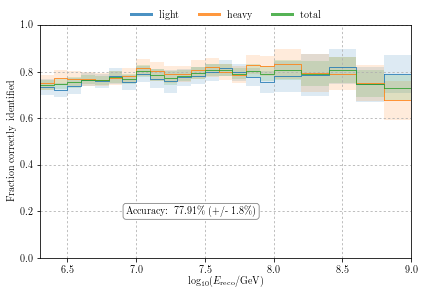

In [13]:
# Plot fraction of events correctlt classified vs energy
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_bins, reco_frac[composition], err, ax,
                        color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Accuracy: {:0.2f}\% (+/- {:0.1f}\%)'.format(avg_frac_correct*100, avg_frac_correct_err*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))
plt.show()